In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
 
# Configurable Parameters
EPOCHS = 10
BATCH_SIZE = 32
LOSS = tf.keras.metrics.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.SGD()
METRIC = ['accuracy']

In [2]:
def plot_errors(history, epochs):
    # Plotting Train and Validation Loss

    epochs_range = list(range(1, epochs + 1))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(1, figsize=(10, 6))
    plt.plot(epochs_range, train_loss, label='train_loss')
    plt.plot(epochs_range, val_loss, label='validation_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical Cross Entropy')
    plt.legend()
    plt.show()


def plot_confusion_matrix(y_test, y_pred, classes=[]):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(1, figsize=(16, 8))
    sns.set(font_scale=1.5, color_codes=True, palette='deep')
    sns.heatmap(cm_df, annot=True, annot_kws={'size': 16}, fmt='d', cmap='YlGnBu')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title('Confusion Matrix')
    plt.show()


def model_training(model, X_train, y_train, X_cv, y_cv, epochs, 
                   batch_size,loss, optimizer, metrics):
    
    # Initialise optimizers
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Enabling Early Stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

    # Enabling check point
    mc = ModelCheckpoint(filepath='bestModel.h5', monitor='val_acc', 
                         mode='max', verbose=1, save_best_only=True)

    # Model fitting
    history = model.fit(X_train, y_train, validation_data=(X_cv, y_cv), 
                        epochs=epochs, batch_size=batch_size,
                        verbose=1, callbacks=[es, mc])

    return model, history

In [3]:
class AlexNet:
    
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
    
    def model_initialise(self):
        
        # Define the AlexNet Architecture
        ip = Input(shape= self.input_shape)
        
        # 1st Convolutional Layer followed by Response Normalised and Pooling
        x = Conv2D(filters=96, kernel_size=(11,11), padding="same", strides=(4,4), activation ="relu")(ip)
        x = layers.Lambda(tf.nn.local_response_normalization)(x)
        x = MaxPooling2D(pool_size = (3,3),  padding="same", strides=(2,2))(x)
        
        # 2nd Convolutional Layer followed by Response Normalised and Pooling
        x = Conv2D(filters=256, kernel_size=(5,5), padding="same", strides=(2,2), activation = "relu")(x)
        x = layers.Lambda(tf.nn.local_response_normalization)(x)
        x = MaxPooling2D(pool_size = (3,3), padding="same", strides=(2,2))(x)
        
        # 3rd Convolutional Layer 
        x = Conv2D(filters=384, kernel_size=(3,3), padding="same", strides=(1,1), activation = "relu")(x)
        
        # 4th Convolutional Layer 
        x = Conv2D(filters=384, kernel_size=(3,3), padding="same", strides=(1,1), activation = "relu")(x)
        
        # 5th Convolutional Layer followed by Response Normalised and Pooling
        x = Conv2D(filters=256, kernel_size=(3,3), padding="same", strides=(1,1), activation = "relu")(x)
        x = layers.Lambda(tf.nn.local_response_normalization)(x)
        x = MaxPooling2D(pool_size = (3,3), padding="same", strides=(2,2))(x)
        
        # Flattening
        x = Flatten()(x)
        
        # 1st Fully Connected Layer with DropOuts
        x = Dense(units=4096, activation="relu")(x)
        x = Dropout(0.5)(x)
        
        # 2nd Fully Connected Layer with DropOuts
        x = Dense(units=4096, activation="relu")(x)
        x = Dropout(0.5)(x)
        
        # Output Layer
        op = Dense(units=self.output_shape, activation="softmax")(x)
        
        # Define Model
        model = Model(inputs=ip, outputs=op)
        
        model.summary()
        
        return model
        

In [4]:
# Loading the dataset and perform splitting
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Resize image to 32x 32
X_train = np.array([np.pad(X_train[i], pad_width=2) for i in range(X_train.shape[0])])
X_test = np.array([np.pad(X_test[i], pad_width=2) for i in range(X_test.shape[0])])

# Performing reshaping operation
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

# Normalization
X_train = X_train / 255
X_test = X_test / 255

# One Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Define image size and number of classes
image_size = X_train.shape[1:]
classes = y_train.shape[1]

print(f"Size of each image = {image_size}")
print(f"Nos of Classes = {classes}")

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
Size of each image = (32, 32, 1)
Nos of Classes = 10


In [5]:
# Create model instance and initialise Lenet Model
alexnet = AlexNet(image_size, classes)
model = alexnet.model_initialise()

epochs = EPOCHS
batch_size = BATCH_SIZE
loss = LOSS
optimizer = OPTIMIZER
metric = METRIC
model, history = model_training(model, X_train, y_train, X_test, y_test, 
                                epochs, batch_size,
                                loss, optimizer, metric)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 96)          11712     
_________________________________________________________________
lambda (Lambda)              (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 256)         614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 2, 2, 256)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 256)         0     

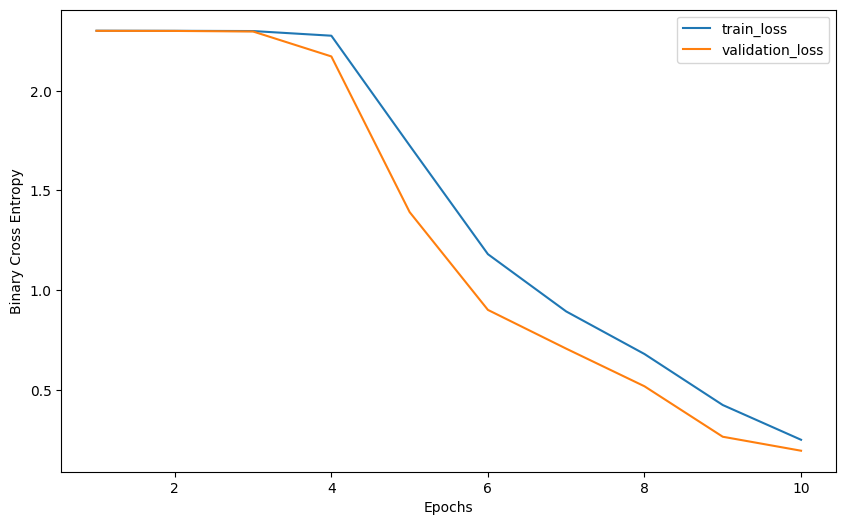

In [6]:
# Plot trainning and test error
plot_errors(history, min(epochs, len(history.history['loss'])))

# Perform Prediction
y_pred = model.predict(X_test)

# Get list of prediction
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

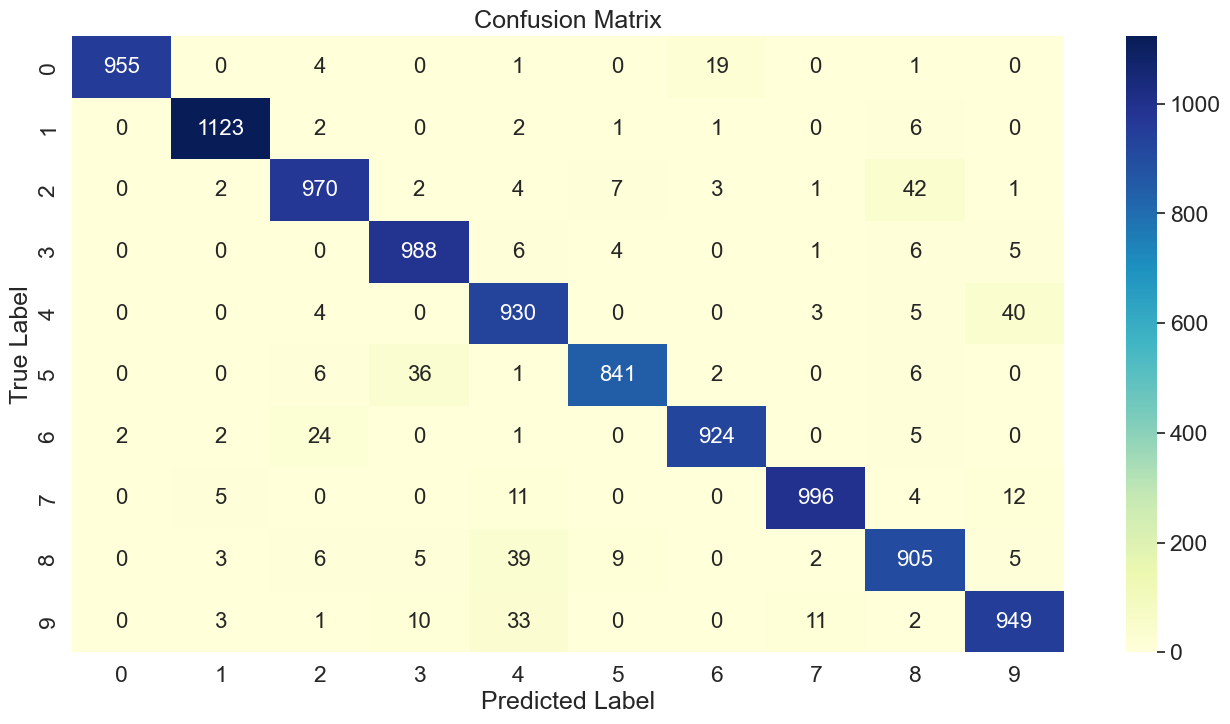

In [7]:
# Show Confusion Matrix
plot_confusion_matrix(y_test, y_pred, list(range(classes)))